## Fouesnau Catalog Plots

In [9]:
from astroquery.gaia import Gaia
import warnings

# Comment this out if you want to see warnings
warnings.filterwarnings('ignore')
import astropy
import requests
import pyvo as vo
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import pandas as pd
import glob
import os
import requests
import sys
sys.path.append("../gaia_tools/")
import data_analysis
import covariance_generation as cov
from import_functions import import_data
import vaex

In [2]:
df=vaex.open('/scratch/sven/gaia_downloads/catalog-20210311-goodphot_lite_nodup.vaex.hdf5')
df['source_id'] = df.source_id.astype('int64')

## Catalog Plots Without Radial Velocity

Uncorrected vs extinction corrected 2MASS

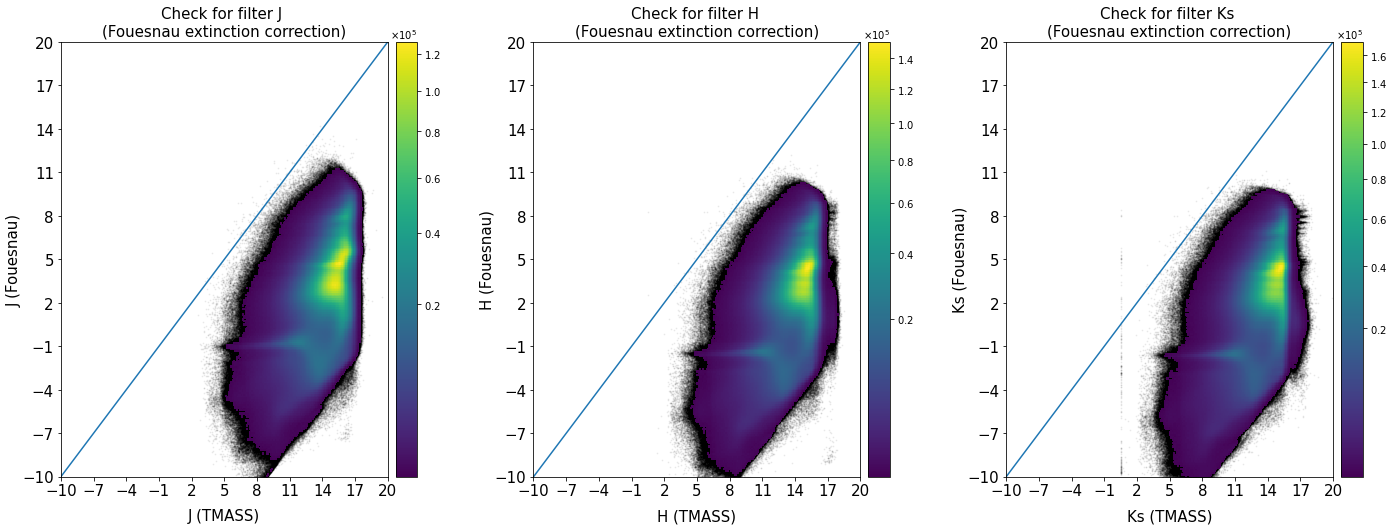

In [71]:
from matplotlib import colors
plt.rc('text', usetex=False)

filters_fouesnau = ['J', 'H', 'Ks']
filters_tmass = ['j_m', 'h_m', 'k_m']

fig, axs = plt.subplots(nrows=1, ncols=3,figsize = (24,8))

for i, filter in enumerate(filters_tmass):

    x_values = df[filters_fouesnau[i]].values
    y_values = df[filters_fouesnau[i]+'_p50'].values

    range = [[-10, 20], [-10, 20]]

    h = axs[i].hist2d(x_values, y_values, range=range, bins=250, cmin=50, norm=colors.PowerNorm(0.5), zorder=0.5)
    axs[i].scatter(x_values, y_values, alpha=0.05, s=1, color='k', zorder=0)

    fmt = mpl.ticker.ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((0, 0))
    cb = fig.colorbar(h[3], ax=axs[i], pad=0.02, format=fmt)

    x_line = np.linspace(-10, 20, 11)
    y_line = np.linspace(-10, 20, 11)

    axs[i].plot(x_line, y_line)

    axs[i].set_xlabel('{} (TMASS)'.format(filters_fouesnau[i]), fontdict={'fontsize': 15}, labelpad=10)
    axs[i].set_ylabel('{} (Fouesnau)'.format(filters_fouesnau[i]), fontdict={'fontsize': 15}, labelpad=0)

    axs[i].tick_params(axis='both', which='major', labelsize=15)

    axs[i].set_xticks(x_line)
    axs[i].set_yticks(y_line)

    axs[i].set_title('Check for filter {} \n(Fouesnau extinction correction)'.format(filters_fouesnau[i]), fontdict={'fontsize': 15})

fig_name = 'No_correction_2MASS_VS_extinction_corrected_2MASS'
plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/' + fig_name +'.png',bbox_inches='tight',  dpi=300, facecolor='white')

Data distribution in Fouseneau catalog

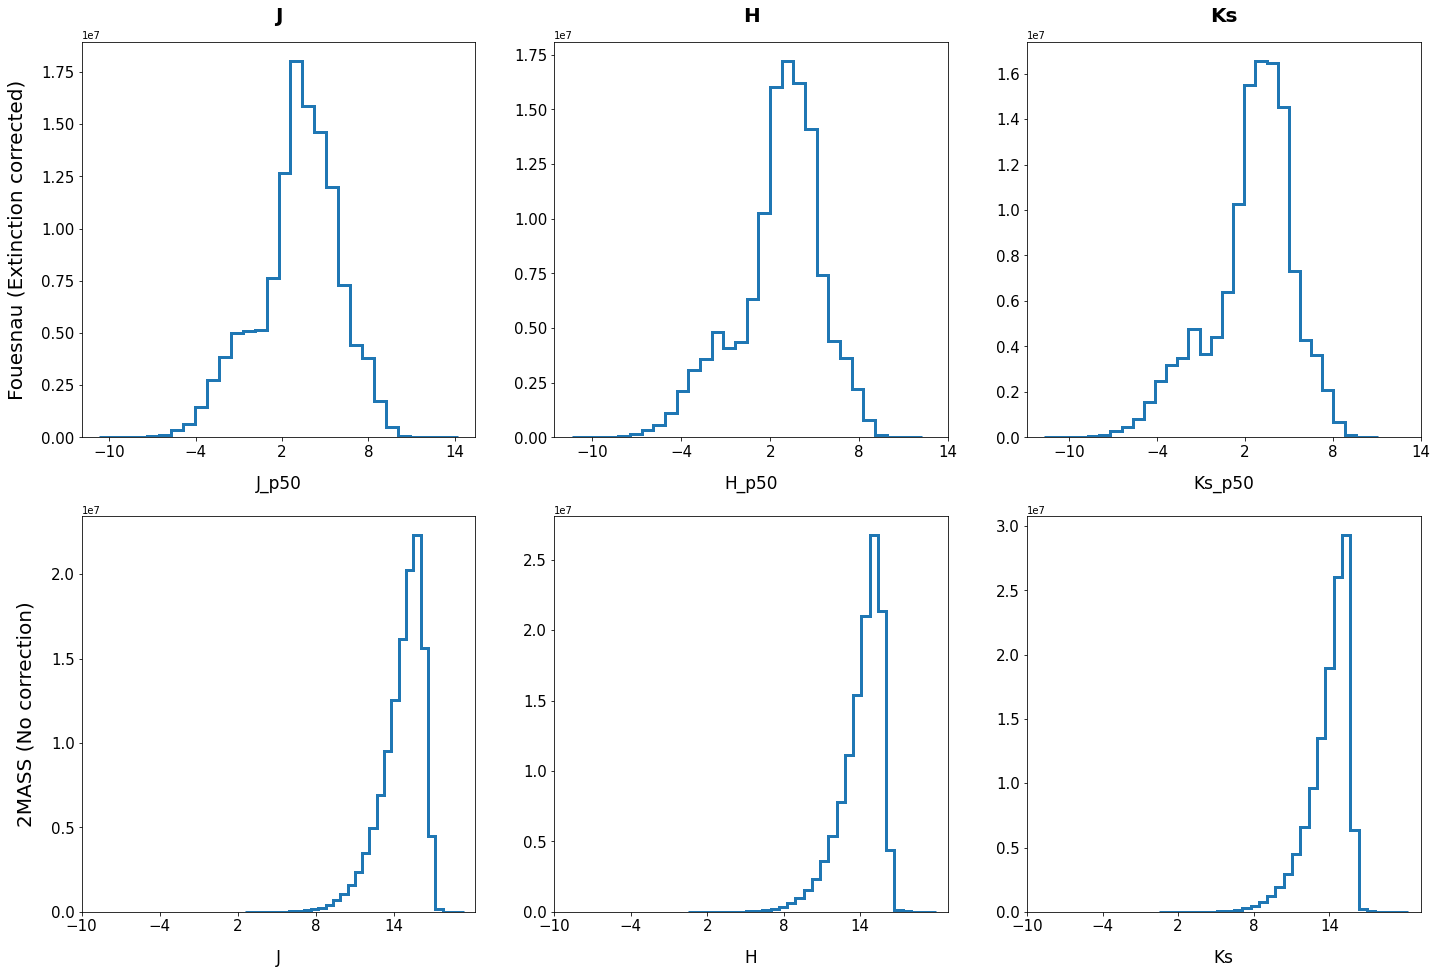

In [70]:
filters_fouesnau = ['J_p50', 'H_p50', 'Ks_p50']
filters_TMASS = ['J', 'H', 'Ks']
filters = filters_fouesnau+filters_TMASS

row_titles = ['Fouesnau (Extinction corrected)', '2MASS (No correction)']

fig, axs = plt.subplots(nrows=2, ncols=3,figsize = (24,16))

for ax,col in zip(axs[0], filters_TMASS):
    ax.set_title(col, fontdict={'fontsize': 20}, pad=20, fontweight='bold')

for ax,row in zip(axs[:,0], row_titles):
    ax.set_ylabel(row, fontdict={'fontsize': 20}, labelpad=15)

for i, ax in enumerate(axs.flat):

    x_values = df[filters[i]].values
    ax.hist(x_values, bins=30, histtype='step', density=False, lw=3)
    ax.set_xlabel('{}'.format(filters[i]), fontdict={'fontsize': 17}, labelpad=15)
    ax.set_xticks(np.linspace(-10, 14, 5))
    ax.tick_params(axis='both', which='major', labelsize=15)

fig_name = 'filter_distributions'
plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/' + fig_name +'.png', bbox_inches='tight', dpi=300, facecolor='white')


----

---

## Comining Fouesneau, Gaia RV and 2MASS data

In [16]:
# Load crossmatched 2MASS IDs

tmass_data = vaex.from_csv('/scratch/sven/gaia_downloads/crossmatche_tmass_IDs.csv', convert=True)
tmass_data.shape

(7070737, 2)

In [17]:
# Join on 'source_id' with Fouseneau catalog

df_join = df.join(tmass_data, how='inner', left_on='source_id', right_on='source_id')

In [18]:
# Add 2MASS data to data frame

tmass_data_path = '/scratch/sven/gaia_downloads/crossmatched_tmass_data.csv'
crossmatched_tmass_data = vaex.from_csv(tmass_data_path, convert=True)
crossmatched_tmass_data = crossmatched_tmass_data.join(df_join, how='inner', 
                            left_on='source_id', 
                            right_on='source_id',
                            lsuffix='_tmass_xmass',
                            rsuffix='_fouesnau')

In [19]:
# Load RV sample data and 

gaia_rv_data = vaex.from_csv('/scratch/sven/gaia_downloads/bayesian_distance_rv_stars.csv', convert=True)

crossmatched_tmass_data = crossmatched_tmass_data.join(gaia_rv_data, how='inner', 
                            left_on='source_id_tmass_xmass', 
                            right_on='source_id',
                            lsuffix='_tmass_xmass',
                            rsuffix='_rv_data')

## Checks between Fouesnau and Crossmatched 2MASS

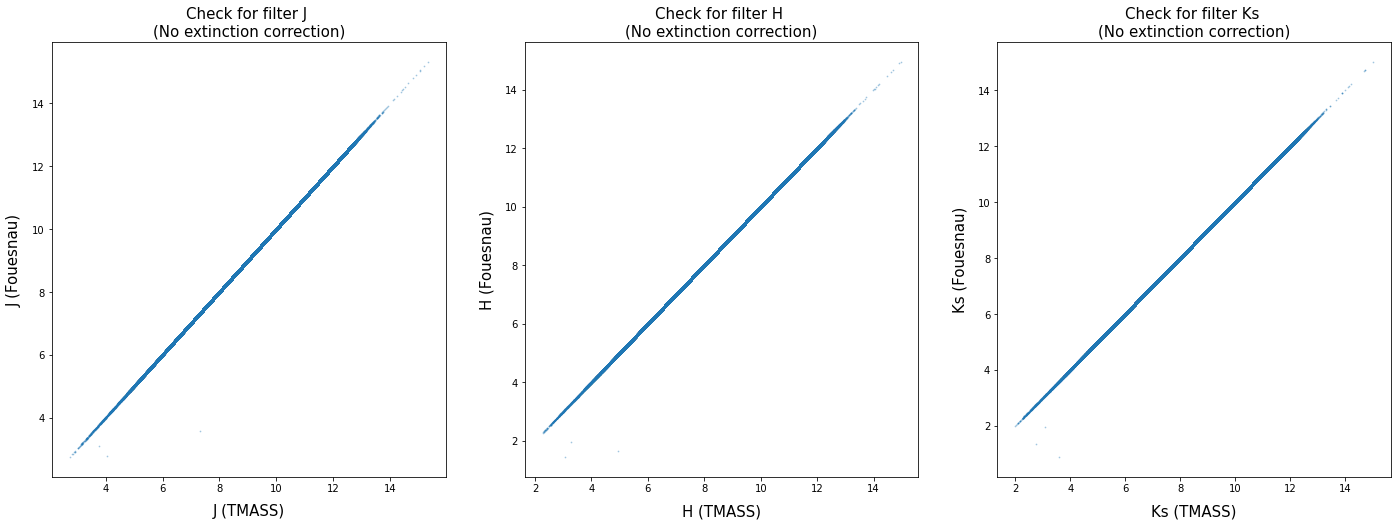

In [20]:
filters_fouesnau = ['J', 'H', 'Ks']
filters_tmass = ['j_m', 'h_m', 'k_m']

fig, axs = plt.subplots(nrows=1, ncols=3,figsize = (24,8))

for i, filter in enumerate(filters_tmass):

    x_values = crossmatched_tmass_data[filters_tmass[i]].values
    y_values = crossmatched_tmass_data[filters_fouesnau[i]].values

    axs[i].scatter(x_values, y_values, alpha=0.3, s = 0.7)
    axs[i].set_xlabel('{} (TMASS)'.format(filters_fouesnau[i]), fontdict={'fontsize': 15}, labelpad=10)
    axs[i].set_ylabel('{} (Fouesnau)'.format(filters_fouesnau[i]), fontdict={'fontsize': 15}, labelpad=10)

    axs[i].set_title('Check for filter {} \n(No extinction correction)'.format(filters_fouesnau[i]), fontdict={'fontsize': 15})

fig_name = 'sanity_check_no_correction'
plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/' + fig_name +'.png', dpi=300, facecolor='white')


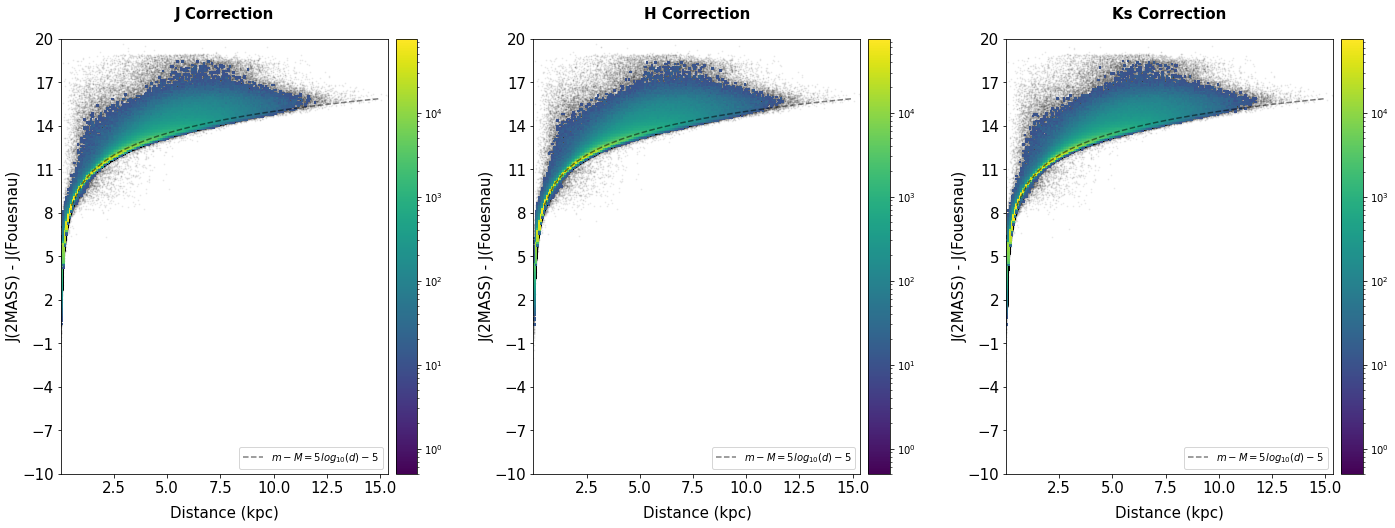

In [72]:
from matplotlib import colors
plt.rc('text', usetex=False)

filters_fouesnau = ['J', 'H', 'Ks']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (24,8))

for i, filter in enumerate(filters_fouesnau):

    x_values = crossmatched_tmass_data.r_est.values
    y_values = crossmatched_tmass_data[filters_fouesnau[i]].values - crossmatched_tmass_data[filters_fouesnau[i]+'_p50'].values

    h = axs[i].hist2d(x_values, y_values, bins=200, cmin=10, norm=colors.LogNorm(0.5), zorder=0.5)
    axs[i].scatter(x_values, y_values, alpha=0.05, s=1, color='k', zorder=0)
    cb = fig.colorbar(h[3], ax=axs[i], pad=0.02)

    # Theoretical
    x_line = np.linspace(0, 15000, 31)
    axs[i].plot(x_line, 5*np.log10(x_line) - 5, 
                linestyle='dashed', 
                lw=1.5,
                alpha=0.5, 
                zorder=0.6, 
                color='black',
                label='$m - M = 5log_{10}(d) - 5$')

    axs[i].set_xlabel('Distance (kpc)', fontdict={'fontsize': 15}, labelpad=10)
    axs[i].set_ylabel('J(2MASS) - J(Fouesnau)', fontdict={'fontsize': 15}, labelpad=0)
    axs[i].legend(loc="lower right")

    def numfmt(x, pos):
        s = '{}'.format(x / 1000.0)
        return s
    yfmt = ticker.FuncFormatter(numfmt)
    axs[i].xaxis.set_major_formatter(yfmt)


    axs[i].tick_params(axis='both', which='major', labelsize=15)

    axs[i].set_yticks(y_line)

    axs[i].set_title('{} Correction'.format(filters_fouesnau[i]), fontdict={'fontsize': 15}, pad=20, fontweight='bold')

fig_name = 'extinction_corrected_2MASS_vs_distance'
plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/' + fig_name +'.png', bbox_inches='tight', dpi=300, facecolor='white')

$5log_{10}(d_{pc}) - 5$

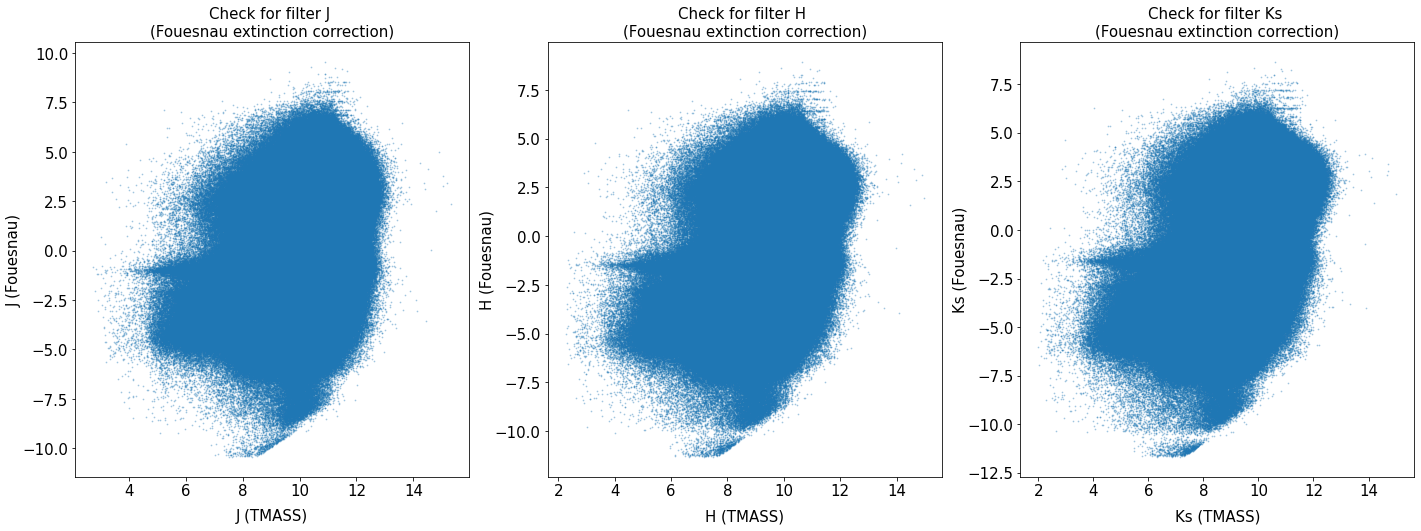

In [104]:
filters_fouesnau = ['J', 'H', 'Ks']
filters_tmass = ['j_m', 'h_m', 'k_m']

fig, axs = plt.subplots(nrows=1, ncols=3,figsize = (24,8))

for i, filter in enumerate(filters_tmass):

    x_values = crossmatched_tmass_data[filters_tmass[i]].values
    y_values = crossmatched_tmass_data[filters_fouesnau[i]+'_p50'].values

    axs[i].scatter(x_values, y_values, alpha=0.3, s = 0.7)
    axs[i].set_xlabel('{} (TMASS)'.format(filters_fouesnau[i]), fontdict={'fontsize': 15}, labelpad=10)
    axs[i].set_ylabel('{} (Fouesnau)'.format(filters_fouesnau[i]), fontdict={'fontsize': 15}, labelpad=0)
    axs[i].tick_params(axis='both', which='major', labelsize=15)
    axs[i].set_title('Check for filter {} \n(Fouesnau extinction correction)'.format(filters_fouesnau[i]), fontdict={'fontsize': 15})

fig_name = 'No_correction_2MASS_VS_extinction_corrected_2MASS'
plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/' + fig_name +'.png', dpi=300, facecolor='white')

## Histograms (NO CUT)

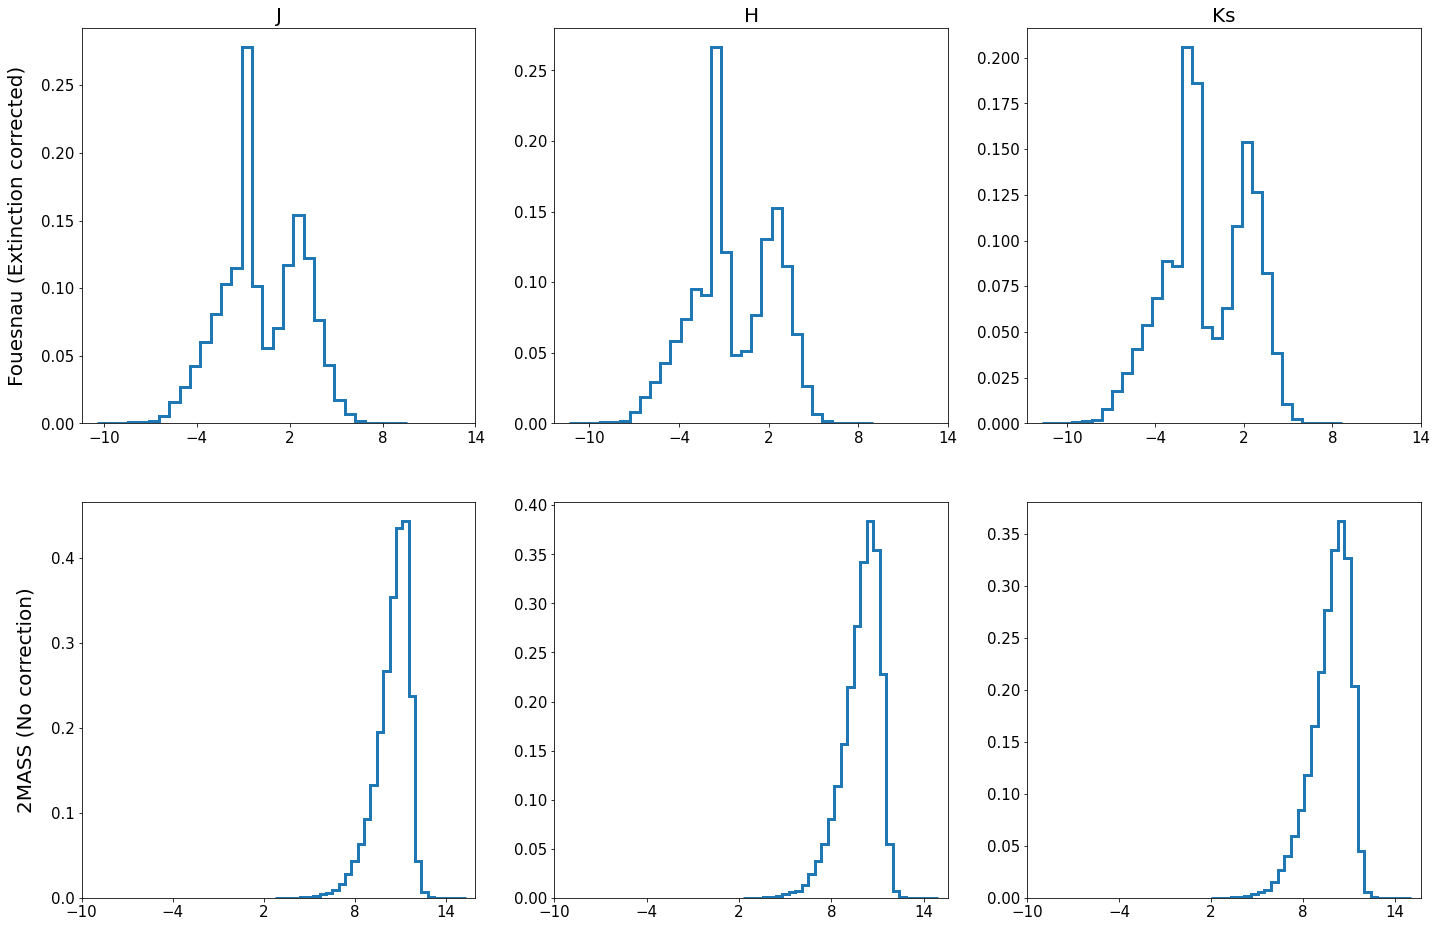

In [103]:
filters_fouesnau = ['J_p50', 'H_p50', 'Ks_p50']
filters_tmass = ['j_m', 'h_m', 'k_m']
filters = filters_fouesnau+filters_tmass
filter_titles = ['J', 'H', 'Ks']

row_titles = ['Fouesnau (Extinction corrected)', '2MASS (No correction)']

fig, axs = plt.subplots(nrows=2, ncols=3,figsize = (24,16))

for ax,col in zip(axs[0], filter_titles):
    ax.set_title(col, fontdict={'fontsize': 20})

for ax,row in zip(axs[:,0], row_titles):
    ax.set_ylabel(row, fontdict={'fontsize': 20}, labelpad=15)

for i, ax in enumerate(axs.flat):
    x_values = crossmatched_tmass_data[filters[i]].values
    ax.hist(x_values, bins=30, histtype='step', density=True, lw=3)
    #ax.set_xlabel('{}'.format(filters[i]), fontdict={'fontsize': 17}, labelpad=15)
    ax.set_xticks(np.linspace(-10, 14, 5))
    ax.tick_params(axis='both', which='major', labelsize=15)

fig_name = 'filter_distributions'
plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/' + fig_name +'.png', dpi=300, facecolor='white')


In [13]:
import numpy as np
import matplotlib.pyplot as plt


def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, alpha=0.1, s=0.5)
    ax.set_xlim(-2, 4)
    ax.set_ylim(-12, 12)

    ax.set_xlabel(r'$J - K_s$ [mag]', fontdict={'fontsize' : 14})
    ax.set_ylabel(r'$H$ [mag]',  fontdict={'fontsize' : 14})


    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    bins = 40
    ax_histx.hist(x, bins=bins, histtype='step', linewidth = 2, density=True)
    ax_histy.hist(y, bins=bins, histtype='step', linewidth = 2, orientation='horizontal', density=True)

    ax_histx.set_yticks([])
    ax_histy.set_xticks([])

    ax.vlines([0.5, 1.1], -12, 14, linestyles='dashed', alpha=0.5, colors='b')
    #ax.hlines([0], 0.5, 1.1, linestyles='dashed', alpha=0.5,  colors='b')

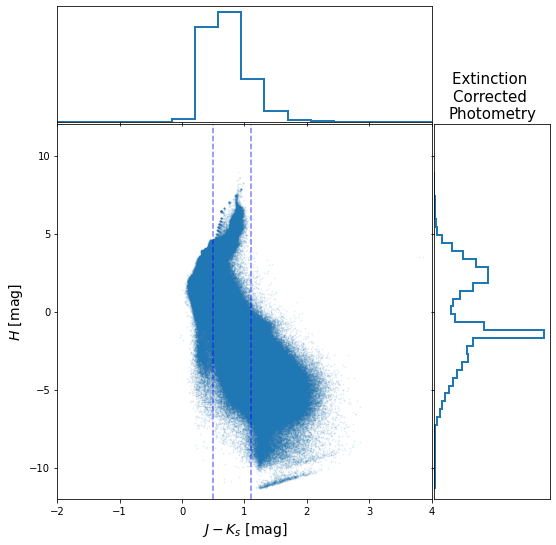

In [14]:
x_values = (crossmatched_tmass_data.J_p50 - crossmatched_tmass_data.Ks_p50).values
y_values = crossmatched_tmass_data.H_p50.values

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(x_values,y_values, ax, ax_histx, ax_histy)
plt.title("Extinction \nCorrected \nPhotometry", fontdict={'fontsize' : 15})
#plt.show()

fig_name = 'color_index_vs_H_NOCUT'
plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/' + fig_name +'.png', dpi=300, facecolor='white')

---

# CUTS ON FOUSENAU DATA

In [106]:
import re
def is_allowed_flg(string):

    charRe = re.compile(r'[^A-B]')
    string = charRe.search(string)
    return not bool(string)

crossmatched_tmass_data =  crossmatched_tmass_data[crossmatched_tmass_data.apply(lambda row : is_allowed_flg(row.ph_qual), axis=1) == True]


TypeError: apply() got an unexpected keyword argument 'axis'

In [8]:
crossmatched_tmass_data = crossmatched_tmass_data[((crossmatched_tmass_data.J_p50 - crossmatched_tmass_data.Ks_p50) > 0.5) & ((crossmatched_tmass_data.J_p50 - crossmatched_tmass_data.Ks_p50) < 1.1)]
crossmatched_tmass_data = crossmatched_tmass_data[(crossmatched_tmass_data.J_sigma < 0.1) & (crossmatched_tmass_data.Ks_sigma < 0.1) & (crossmatched_tmass_data.H_sigma < 0.1)]

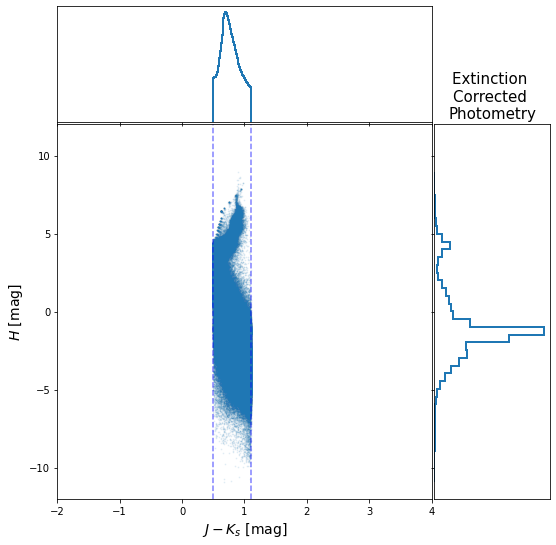

In [16]:
x_values = (crossmatched_tmass_data.J_p50 - crossmatched_tmass_data.Ks_p50).values
y_values = crossmatched_tmass_data.H_p50.values

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(x_values,y_values, ax, ax_histx, ax_histy)
plt.title("Extinction \nCorrected \nPhotometry", fontdict={'fontsize' : 15})
#plt.show()

fig_name = 'color_index_vs_H_CUT'
plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/' + fig_name +'.png', dpi=300, facecolor='white')

# Checking Gaia photometry

In [31]:
gaia_rv_data = vaex.from_csv('/scratch/sven/gaia_downloads/bayesian_distance_rv_stars.csv', convert=True)
print(gaia_rv_data.shape)
print(gaia_rv_data.get_column_names)

(7183262, 2)
<bound method DataFrame.get_column_names of #          source_id            r_est
0          4046915582991998848  422.967322928351
1          4317703654609156352  3775.50836965521
2          4317691663059788800  2818.35033898823
3          4305432005322658176  3100.1573210262895
4          1819579662510463744  1722.7734562922
...        ...                  ...
7,183,257  1824878213383370368  3724.1725763354707
7,183,258  1824878419541813760  2327.39026131402
7,183,259  1824500393718295168  467.239826862621
7,183,260  1824501935542975488  1443.7721587892001
7,183,261  1824515477644677632  5500.54085332704>


In [10]:
gaia_photometry = vaex.from_csv('/scratch/sven/gaia_downloads/gaia_photometry_rv_data.csv', convert=True)
gaia_photometry.shape


(7224631, 13)

In [11]:
gaia_photometry_df = crossmatched_tmass_data.join(gaia_photometry, 
                                                    how='inner', 
                                                    left_on='source_id_tmass_xmass', 
                                                    right_on='source_id',
                                                    lsuffix='_tmass_xmass',
                                                    rsuffix='_gaia_phot')

In [28]:
print(gaia_photometry_df.G_p50[0:1].values)
print(gaia_photometry_df.phot_g_mean_mag[0:1].values)
print(gaia_photometry_df.G[0:1].values)
print(gaia_photometry_df.A_G_p50[0:1].values)
print(gaia_photometry_df.A0_p50[0:1].values)



[7.843140125274658]
[12.032131]
[12.032099723815918]
[1.3792200088500977]
[1.6923199892044067]


In [29]:
#print(gaia_photometry_df.shape)
print(crossmatched_tmass_data.shape)

(2679702, 208)


In [32]:
gaia_photometry_df = gaia_photometry_df.join(gaia_rv_data, 
                                                    how='inner', 
                                                    left_on='source_id_tmass_xmass', 
                                                    right_on='source_id',
                                                    lsuffix='_gaia_phot',
                                                    rsuffix='_gaia_rv')

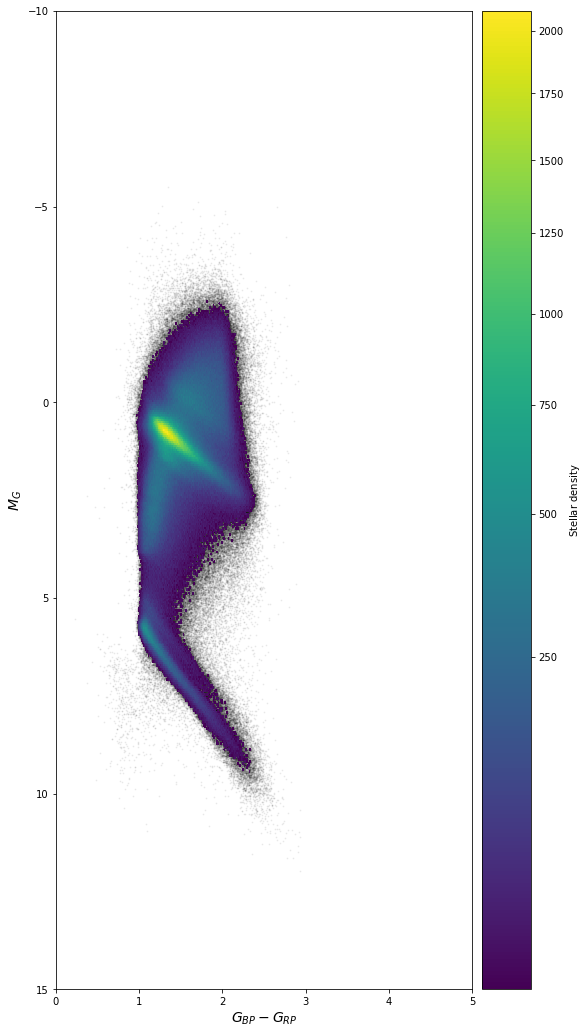

In [33]:
from matplotlib import colors
plt.rc('text', usetex=False)

fig, ax = plt.subplots(figsize=(9, 18))

range = [[0,5], [-10, 15]]

Mg = gaia_photometry_df.phot_g_mean_mag.values - 5*np.log10(gaia_photometry_df.r_est.values) + 5

# only show 2D-histogram for bins with more than 10 stars in them
h = ax.hist2d(gaia_photometry_df.bp_rp.values, Mg, range=range, bins=500, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5)
# fill the rest with scatter (set rasterized=True if saving as vector graphics)
ax.scatter(gaia_photometry_df.bp_rp.values, Mg, alpha=0.05, s=1, color='k', zorder=0)

ax.invert_yaxis()
cb = fig.colorbar(h[3], ax=ax, pad=0.02)
ax.set_xlabel('$G_{BP} - G_{RP}$', fontdict={'size' : 14})
ax.set_ylabel('$M_G$', fontdict={'size' : 14})
cb.set_label("$\mathrm{Stellar~density}$")
plt.show()

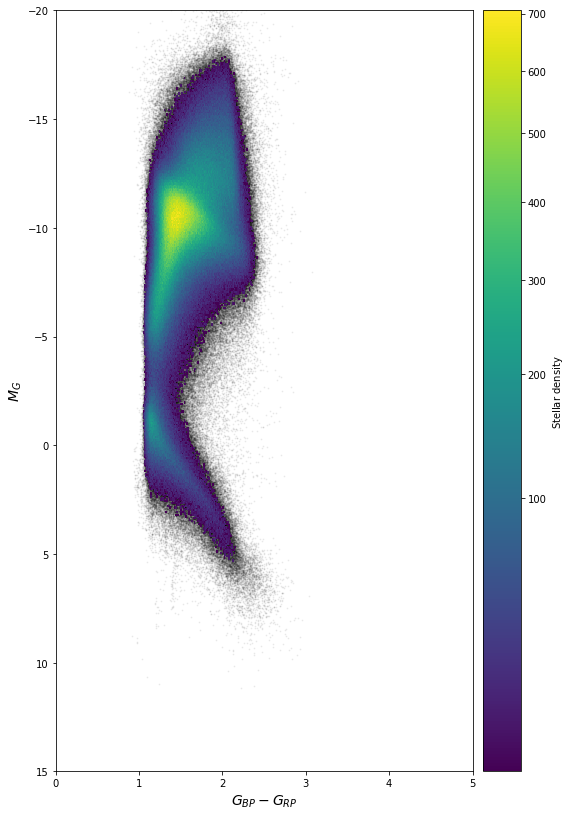

In [36]:
from matplotlib import colors
plt.rc('text', usetex=False)

fig, ax = plt.subplots(figsize=(9, 14))

range = [[0,5], [-20, 15]]

Mg = gaia_photometry_df.G_p50.values - 5*np.log10(gaia_photometry_df.r_est.values) + 5

# only show 2D-histogram for bins with more than 10 stars in them
h = ax.hist2d(gaia_photometry_df.BP_p50.values - gaia_photometry_df.RP_p50.values, Mg, range=range, bins=500, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5)
# fill the rest with scatter (set rasterized=True if saving as vector graphics)
ax.scatter(gaia_photometry_df.BP_p50.values - gaia_photometry_df.RP_p50.values, Mg, alpha=0.05, s=1, color='k', zorder=0)

ax.invert_yaxis()
cb = fig.colorbar(h[3], ax=ax, pad=0.02)
ax.set_xlabel('$G_{BP} - G_{RP}$', fontdict={'size' : 14})
ax.set_ylabel('$M_G$', fontdict={'size' : 14})
cb.set_label("$\mathrm{Stellar~density}$")
plt.show()